In [22]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set paths for datasets
emo_db_path = "EmoDB"
ravdess_path = "RAVDESS" 


# Function to load and explore dataset
def explore_dataset(dataset_path, dataset_name):
    print(f"\nExploring {dataset_name} dataset:")
    audio_files = []
    emotions = []
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
                # Extract emotion from filename based on dataset
                if dataset_name == "EmoDB":
                    # EmoDB naming convention: [a-z]{2}[0-9]{2}.wav
                    # First two letters represent emotion
                    emotion_code = file[:2]
                    emotion_map = {
                        'W': 'anger', 'L': 'boredom', 'E': 'disgust',
                        'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'
                    }
                    emotions.append(emotion_map.get(emotion_code[0], 'unknown'))
                elif dataset_name == "RAVDESS":
                    # RAVDESS naming convention: [0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}.wav
                    # Third number represents emotion
                    emotion_code = int(file.split('-')[2])
                    emotion_map = {
                        1: 'neutral', 2: 'calm', 3: 'happy',
                        4: 'sad', 5: 'angry', 6: 'fearful',
                        7: 'disgust', 8: 'surprised'
                    }
                    emotions.append(emotion_map.get(emotion_code, 'unknown'))
    
    # Create DataFrame
    df = pd.DataFrame({'file_path': audio_files, 'emotion': emotions})
    
    # Display basic info
    print(f"Total audio files: {len(df)}")
    print("Emotion distribution:")
    print(df['emotion'].value_counts())
    
    return df

# Load datasets
emo_df = explore_dataset(emo_db_path, "EmoDB")
ravdess_df = explore_dataset(ravdess_path, "RAVDESS")


Exploring EmoDB dataset:
Total audio files: 535
Emotion distribution:
emotion
unknown    535
Name: count, dtype: int64

Exploring RAVDESS dataset:
Total audio files: 2880
Emotion distribution:
emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64


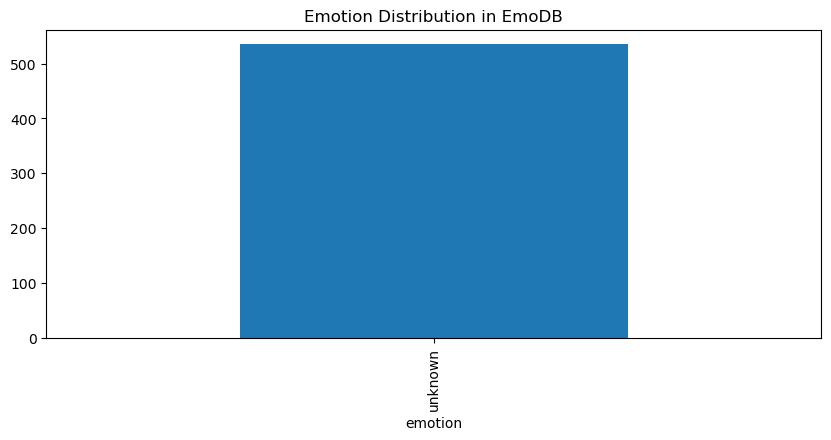

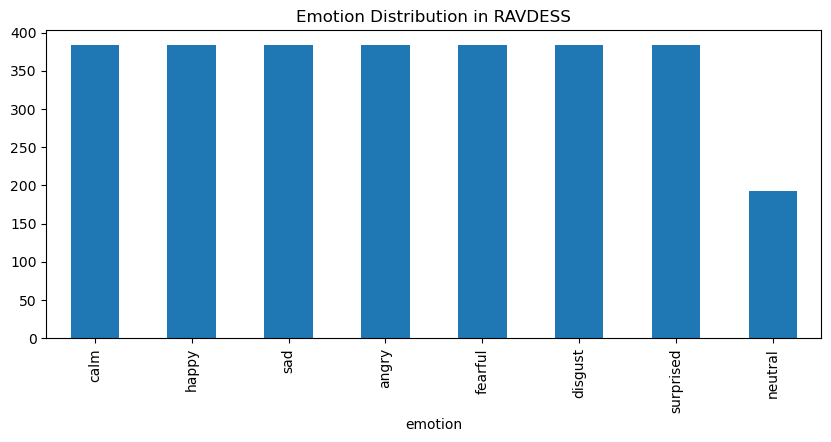

In [20]:
# Plot emotion distribution
plt.figure(figsize=(10, 4))
emo_df['emotion'].value_counts().plot(kind='bar')
plt.title("Emotion Distribution in EmoDB")
plt.show()
def plot_emotion_distribution(df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, y='emotion', order=df['emotion'].value_counts().index)
    plt.title(f'Emotion Distribution - {title}')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show() 

# Plot emotion distribution
plt.figure(figsize=(10, 4))
ravdess_df['emotion'].value_counts().plot(kind='bar')
plt.title("Emotion Distribution in RAVDESS")
plt.show()
def plot_emotion_distribution(df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, y='emotion', order=df['emotion'].value_counts().index)
    plt.title(f'Emotion Distribution - {title}')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show()

In [31]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft, get_window
from scipy.fft import dct
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Audio processing constants
TARGET_SR = 22050       # Target sample rate
DURATION = 3.0          # Duration in seconds
N_FFT = 512             # FFT window size
HOP_LENGTH = 256        # STFT hop length
N_MELS = 40             # Number of Mel bands
N_MFCC = 13             # Number of MFCC coefficients

def preprocess_audio(file_path):
    try:
        # 1. Load WAV file
        sr, audio = wavfile.read(file_path)
        
        # 2. Convert to mono if stereo
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # 3. Resample if needed
        if sr != TARGET_SR:
            ratio = TARGET_SR / sr
            audio = resample_audio(audio, ratio)
        
        # 4. Trim silence (simple energy-based)
        audio = trim_silence(audio)
        
        # 5. Pad/truncate to fixed duration
        audio = pad_audio(audio, int(DURATION * TARGET_SR))
        
        # 6. Extract MFCC features (pure NumPy/SciPy implementation)
        mfccs = extract_mfcc(audio)
        
        return mfccs
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Helper functions
def resample_audio(audio, ratio):
    """Basic resampling using linear interpolation"""
    n_samples = int(len(audio) * ratio)
    return np.interp(
        np.linspace(0, len(audio), n_samples),
        np.arange(len(audio)),
        audio
    )

def trim_silence(audio, threshold_percentile=10):
    """Simple energy-based silence trimming"""
    energy = np.abs(audio)
    threshold = np.percentile(energy, threshold_percentile)
    mask = energy > threshold
    return audio[np.argmax(mask):len(audio)-np.argmax(mask[::-1])]

def pad_audio(audio, target_length):
    """Pad or truncate audio to target length"""
    if len(audio) > target_length:
        return audio[:target_length]
    return np.pad(audio, (0, max(0, target_length - len(audio))), mode='constant')

def hz_to_mel(f):
    """Convert frequency to Mel scale"""
    return 2595 * np.log10(1 + f / 700)

def mel_to_hz(m):
    """Convert Mel scale to frequency"""
    return 700 * (10 ** (m / 2595) - 1)

def create_mel_filterbank(sr, n_fft, n_mels):
    """Create Mel filter bank"""
    mel_min = hz_to_mel(0)
    mel_max = hz_to_mel(sr / 2)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    
    filterbank = np.zeros((n_mels, n_fft // 2 + 1))
    for i in range(1, n_mels + 1):
        left = bin_points[i - 1]
        center = bin_points[i]
        right = bin_points[i + 1]
        
        # Rising slope
        if center > left:
            filterbank[i - 1, left:center] = np.linspace(0, 1, center - left)
        
        # Falling slope
        if right > center:
            filterbank[i - 1, center:right] = np.linspace(1, 0, right - center)
    
    return filterbank

def extract_mfcc(audio, sr=TARGET_SR, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Pure NumPy/SciPy MFCC implementation"""
    # 1. Compute STFT
    _, _, stft_matrix = stft(
        audio,
        fs=sr,
        window='hann',
        nperseg=n_fft,
        noverlap=n_fft - hop_length
    )
    power_spec = np.abs(stft_matrix) ** 2
    
    # 2. Create Mel filter bank
    mel_filterbank = create_mel_filterbank(sr, n_fft, n_mels)
    
    # 3. Apply Mel filter bank
    mel_spectrogram = np.dot(mel_filterbank, power_spec)
    log_mel_spectrogram = np.log10(mel_spectrogram + 1e-6)  # Add small offset
    
    # 4. Compute DCT to get MFCCs
    mfccs = dct(log_mel_spectrogram, axis=0, type=2, norm='ortho')[:n_mfcc]
    
    # 5. Add delta and delta-delta features
    delta = np.zeros_like(mfccs)
    delta_delta = np.zeros_like(mfccs)
    
    if mfccs.shape[1] > 1:
        delta[:, 1:] = mfccs[:, 1:] - mfccs[:, :-1]
        delta[:, 0] = delta[:, 1]
        
        if mfccs.shape[1] > 2:
            delta_delta[:, 1:] = delta[:, 1:] - delta[:, :-1]
            delta_delta[:, 0] = delta_delta[:, 1]
    
    # Combine features
    features = np.vstack([mfccs, delta, delta_delta])
    
    # Normalize
    features = (features - np.mean(features)) / (np.std(features) + 1e-8)
    
    return features.T  # Transpose to get (time_steps, features)

# Dataset preparation (same as before)
def prepare_dataset(df, dataset_name):
    print(f"\nPreprocessing {dataset_name} dataset...")
    features = []
    valid_indices = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {dataset_name}"):
        feature = preprocess_audio(row['file_path'])
        if feature is not None:
            features.append(feature)
            valid_indices.append(idx)
    
    # Pad sequences to same length
    max_length = max([f.shape[0] for f in features])
    features_padded = np.array([
        np.pad(f, ((0, max_length - f.shape[0]), (0, 0)), mode='constant')
        for f in features
    ])
    
    # Filter only successfully processed files
    df_processed = df.loc[valid_indices].copy()
    X = features_padded
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df_processed['emotion'])
    
    print(f"Final shape: {X.shape}")
    return X, y, le.classes_

# Prepare datasets
X_emo, y_emo, emo_classes = prepare_dataset(emo_df, "EmoDB")
X_rav, y_rav, rav_classes = prepare_dataset(ravdess_df, "RAVDESS")

# Combine datasets
X = np.concatenate((X_emo, X_rav))
y = np.concatenate((y_emo, y_rav))
class_names = np.unique(np.concatenate((emo_classes, rav_classes)))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Preprocessing EmoDB dataset...


Processing EmoDB:  68%|██████▊   | 365/535 [00:04<00:01, 95.20it/s]C:\Users\omar6\AppData\Local\Temp\ipykernel_19192\1704310264.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)
Processing EmoDB: 100%|██████████| 535/535 [00:05<00:00, 89.78it/s]


Final shape: (535, 260, 39)

Preprocessing RAVDESS dataset...


Processing RAVDESS:   0%|          | 0/2880 [00:00<?, ?it/s]C:\Users\omar6\AppData\Local\Temp\ipykernel_19192\1704310264.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)
Processing RAVDESS: 100%|██████████| 2880/2880 [00:41<00:00, 68.60it/s]


Final shape: (2880, 260, 39)


In [111]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Assuming you have X_train and y_train ready from previous steps
print("Original X_train shape:", X_train.shape)

# Reshape X_train to add channel dimension
if len(X_train.shape) == 3:  # (samples, time_steps, features)
    X_train = np.expand_dims(X_train, -1)  # becomes (samples, time_steps, features, 1)
    X_test = np.expand_dims(X_test, -1)
elif len(X_train.shape) == 2:  # (samples, flattened_features)
    # Need to reshape based on your MFCC parameters
    time_steps = X_train.shape[1] // (N_MFCC * 3)  # 3 for mfcc+delta+delta_delta
    X_train = X_train.reshape(-1, time_steps, N_MFCC * 3, 1)
    X_test = X_test.reshape(-1, time_steps, N_MFCC * 3, 1)

print("Reshaped X_train shape:", X_train.shape)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model with corrected input shape
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_cnn_model(input_shape, len(class_names))
model.summary()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, y_pred_classes, class_names)

print("\nTraining History:")
plot_training_history(history)

# Calculate and display overall accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")